<a id="top"></a>
# MIRI MRS Spectroscopy of a Late M Star

**Use case:** Extract spatial-spectral features from IFU cube and measure their attributes.<br>
**Data:** KMOS datacube of point sources in the LMC from Jones et al. (in prep).<br>
**Tools:** specutils, spectral_cube, photutils, astropy, aplpy, scipy.<br>
**Cross-intrument:** MIRI<br>
**Documentation:** This notebook is part of a STScI's larger [post-pipeline Data Analysis Tools Ecosystem](https://jwst-docs.stsci.edu/jwst-post-pipeline-data-analysis).<br>

**Note**: Ultimately, this notebook will include MIRI simulated data cubes obtained using MIRISim (https://wiki.miricle.org//bin/view/Public/MIRISim_Public)
and run through the JWST pipeline (https://jwst-pipeline.readthedocs.io/en/latest/) of
point sources with spectra representative of late M type stars.

## Introduction

This notebook analyzes one star represented by a dusty SED corresponding to the ISO SWS spectrum of
W Per from Kraemer et al. (2002) and Sloan et al. (2003) to cover the MRS spectral range 5-28 microns.  Analysis of JWST spectral cubes requires extracting spatial-spectral features of interest and measuring their attributes. 

The first part of the notebook will process the datacube and automatically detect and extract spectra (summed over its spatial region) for all point sources in the cube.  Then it will read in a datacube generated at Stage 3 of the JWST pipeline or use near-IR data from KMOS as a representative example of an IR data cube.  The analysis will use `photutils` to automatically detect sources in the continuum image and use an aperture mask generated with `spectral-cube` to extract the spectra of each point source in the data cube.

The second part of the notebook will perform data analysis using `specutils`.  Specifically, it will fit a model photosphere/blackbody to the spectra.  Then it will calculate the centroids, line integrated flux and equivalent width for each dust and molecular feature. 

## To Do:
- Replace KMOS data cube with JWST/MIRI simulation of an M star ran through JWST piplieline.
- Make function to extract spectra from datacube using an apeture.
- Replace blackbody fit to the photosphere part of the spectra with a stellar photosphere model.
- Make sure errors have been propagated correctly in the caculation of centroids, line integrated flux and
equivalent widths.
- Make simple function within the `specutils` framework to fit a continium and measure centroids, line integrated flux and
equivalent widths of broad solid state and molecular features.

## Imports

In [1]:
# Import useful python packages
import numpy as np

# Import packages to display images inline in the notebook
import matplotlib.pyplot as plt    
%matplotlib inline   

# Set general plotting options
params={'legend.fontsize':'18','axes.labelsize':'18',
        'axes.titlesize':'18','xtick.labelsize':'18',
        'ytick.labelsize':'18','lines.linewidth':2,'axes.linewidth':2,'animation.html': 'html5'}
plt.rcParams.update(params)
plt.rcParams.update({'figure.max_open_warning': 0})

In [2]:
# Import astropy packages 
from astropy import units as u
from astropy.io import ascii
from astropy.wcs import WCS
from astropy.table import Table, vstack
from astropy.stats import sigma_clipped_stats
from astropy.nddata import StdDevUncertainty

# Import packages to deal with spectralcubes
from spectral_cube import SpectralCube

# To find stars in the MRS spectralcubes and do aperture photometry
from photutils import DAOStarFinder, CircularAperture

# To deal with 1D spectrum
from specutils import Spectrum1D
from specutils.fitting import fit_generic_continuum
from specutils.manipulation import box_smooth, extract_region, SplineInterpolatedResampler
from specutils.analysis import line_flux, centroid, equivalent_width
from specutils.spectra import SpectralRegion

# To make nice plots with WCS axis
import aplpy

# To fit a curve to the data
from scipy.optimize import curve_fit

ImportError: cannot import name 'six' from 'astropy.extern' (/home/jbcurtin/workspace/spacetelescope/dat_pyinthesky/jdat_notebooks/MRS_Mstar_analysis/env/lib/python3.7/site-packages/astropy/extern/__init__.py)

## Set paths to the Data and Outputs

For now use KMOS data cube of YSOs in the LMC from Jones et al in prep.

TODO: Update with MIRISim JWST pipeline processed data in future itterations.

In [10]:
# Setup an input directory where relevant data is located
data_in_path = "https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/MRS_Spectroscopy_Late_M_Star/"

data_cube_file = data_in_path + "NGC346_K_2c_COMBINED_CUBE_Y551.fits"

# Path to output directory
data_out_path = "./"

# Setup an output directory to save the extracted 1D spectra
outdir_spectra = data_out_path + '/spectra/'

In [4]:
# Some housekeeping if using the KMOS data rather than simulated JWST/MRS data
# Define good wavelength ranges for each grating from which to make the data cube
YJgrating = [1.02, 1.358] # microns
Hgrating = [1.44, 1.85]   # microns
Kgrating = [2.1, 2.42]    # microns

## Load and Display the Data cube

**Developer note**  Note the `SpectralCube` package is designed for sub-mm/radio data it expects a beam!
This is preferred to other packages available due to much of its functionality and ease of use.
JWST NIRSpec and MIRI both have instruments that give data cubes (with two positional dimensions and one spectral
dimension) as the final pipeline product, as do many ground based telescopes, which do not have a beam.


https://spectral-cube.readthedocs.io/en/stable/index.html

In [5]:
cube = SpectralCube.read(data_cube_file, hdu=1)  
print(cube)

SpectralCube with shape=(2048, 14, 15) and unit=erg / (Angstrom cm2 s):
 n_x:     15  type_x: RA---TAN  unit_x: deg    range:    14.827541 deg:   14.830852 deg
 n_y:     14  type_y: DEC--TAN  unit_y: deg    range:   -72.158961 deg:  -72.157927 deg
 n_s:   2048  type_s: WAVE      unit_s: m      range:        1.925 um:       2.500 um


/Users/ojones/anaconda3/envs/astro36/lib/python3.6/site-packages/spectral_cube/spectral_cube.py:246: UserWarning: Could not parse beam information from header.  Exception was: NoBeamException('No BMAJ found and does not appear to be a CASA/AIPS header.',)
  "  Exception was: {0}".format(ex.__repr__()))


In [6]:
# Cube dimensions and trimming 
# Data order in cube is (n_spectral, n_y, n_x)

# Trim the ends of the cube where the data quality is poor
subcube = cube.spectral_slab(Kgrating[0] * u.micron, Kgrating[1] * u.micron)

# Rename subcube to equal cube - done in case step above is not necessary
cube = subcube

# Chop out the NaN borders
cmin = cube.minimal_subcube()

In [7]:
# Make a continuum image (Sum/average over Wavelength)
# Note: many mathematical options are available median is preferred
cont_img = cmin.median(axis = 0)

# Extract the target name
name_long = cont_img.header["OBJECT"]
name, _ = name_long.split("/")

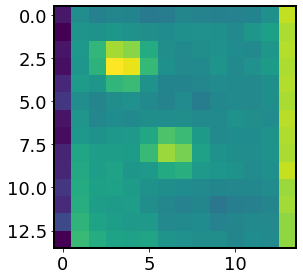

In [8]:
# Quick plot the continuum image now the NaN borders removed
plt.imshow(cont_img.value)
plt.tight_layout()
plt.show()

INFO:astropy:Auto-setting vmin to -1.149e-18
INFO:astropy:Auto-setting vmax to  1.301e-19


INFO: Auto-setting vmin to -1.149e-18 [aplpy.core]
INFO: Auto-setting vmax to  1.301e-19 [aplpy.core]


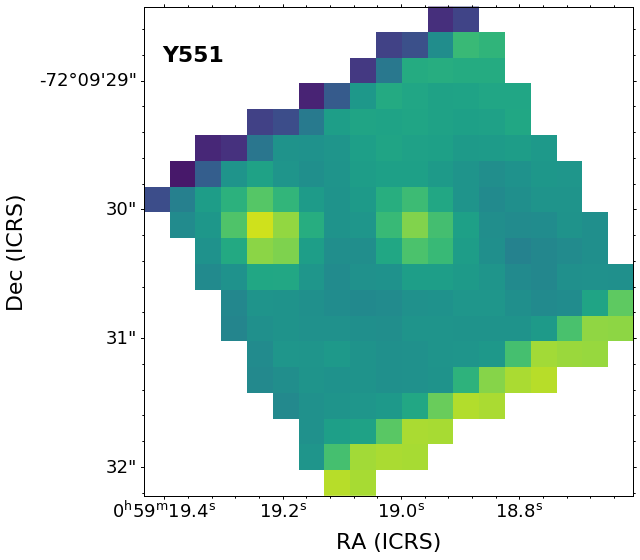

In [9]:
#Plot the continuum in WCS
F = aplpy.FITSFigure(cont_img.hdu, north = True)
F.show_colorscale()
F.add_label(0.1, 0.9, name, relative = True, size = 22, weight = 'bold')
F.axis_labels.set_font(size = 22)
F.tick_labels.set_font(size = 18, stretch = 'condensed')

## Now to detect the point source in the datacube and extract and plot the spectra for each source

**Developer note** Finding a way to streamline the process of detecting sources within a data cube and extracting their
spectra would be extremely valuable.

For data cubes like the JWST/MIRI MRS information on the point sources in the FOV and also obtaining a source subtracted
 data cube will be necessary (See the `PampelMuse` software for an example on how spectral extraction is implemented for
  near-IR data cubes like MUSE).

Note these backgrounds of diffuse emission can be quite complex.

On these source extracted data cubes (see `SUBTRES` in `PampelMuse`) I would like to produce moment maps
(https://casa.nrao.edu/Release3.4.0/docs/UserMan/UserManse41.html) and Position-Velocity (PV) diagrams
(https://casa.nrao.edu/Release4.1.0/doc/UserMan/UserManse42.html).

### 1) Use `Photutils` to detect stars/point sources in the continuum image

The first step of the analysis is to identify those sources for which it is feasible to extract spectra from the IFU
data. Ideally we can estimate the signal-to-noise ratio (S/N) for all sources in the cube, do a number of checks to
determine the status of every source and loop through these (brightest first) to extract the spectra.

### 2) Extract the spectra from the datacube using `SpectralCube`

**Note** There are multiple ways of extracting spectra from datacubes. The simplest is slice the cube along a single
pixel but this is not ideal for point sources which should cover multiple pixels.
Here I use *Aperture Extraction*. 

- The flux from each point source was obtained via a circular aperture. This requires you to mask the data, and make a
circular mask and a maskedsubcube.

- A background measured using a square/rectangular aperture sliced in pixel coordinates to produce a sub-cube.

- A annulus surrounding the point source to measure the local background. 

- Using predefined regions from DS9 etc. to create a mask [`Not used here`].

*If have a small number of data cubes selecting the source extraction region and background region manually using
`cubeviz` would be useful here.*

Mathematical operation e.g. `max, mean, sum, median, std` should then be applied to the region in the aperture.

Below I show a few different options from the simple to the complex, which takes into account the background emission
within the data cube. Taking into account the background may not always be the preferred method but the option should
always be available when using an aperture extraction.

#### Steps to find the background

1) Define a background region either as an annulus or as a rectangle away from the source

2) Find the median of all the background pixels to account for variations 

3) Find number of pixels in background and number of pixels in the point source aperture

4) Find the sum of all the pixels in the point source aperture

5) Correct for background using the sum star flux minus median of background * pixels in star aperture



**Advanced Developer Note** Using Aperture Extraction to obtain the spectra for each source in the data cube is still
very simplistic. It should be noted that the MIRI aperture changes as a function of wavelength, the steps above do not
account for this.
A good example of software that looks at extracting point sources from datacubes is: `PampelMuse`, by Sebastian Kamann. 
https://gitlab.gwdg.de/skamann/pampelmuse; https://ui.adsabs.harvard.edu/abs/2013A%26A...549A..71K/abstract

An `optimal spectrum extraction` procedure would take into account the varying PSF through the cube, to produce an
accurate spectra with the maximum possible signal-to-noise ratio. This weights the extracted data by the S/N of each
pixel (Horne 1986) and would be ideal for when there is a complex background or for extracting spatially-blended source.
For small cubes its best to fit a PSF profile to all resolved sources simultaneously, but this might not be possible in
larger data sets.

**Advanced Developer Note 2** In dense fields like globular clusters, with a significant number of unresolved sources or
 in embedded star-forming clusters, a more advanced treatment of the background would be necessary. For instance using a
 homogeneous grid across the field of view with parameters controlling the bin size would be ideal. If a variable
 background is not accounted for in a PSF extraction systematic residuals in the data would be present where background
 is over or underestimated.



## Detect, extract and plot 1D spectrum of each source in the cube 

### First automatically identify all the point sources in the cube using `photutils`

In [10]:
# Make an array to store results of the source detection within the data cube
name_val = []
source_val = []
ra_val =[]
dec_val =[]

In [11]:
# Crop out Edges and take absolute value of the continuum image
cont_img = cont_img[1:13, 1:13]

# Find the background in the collapsed datacube
mean, median, std = sigma_clipped_stats(cont_img.value, sigma = 2.0)

# Get a list of sources using a dedicated source detection algorithm
# Find sources at least 3* background (typically)

daofind = DAOStarFinder(fwhm = 2.0, threshold = 3. * std)
sources = daofind(cont_img.value - median) 
print("\n Number of sources in field: ", len(sources))


 Number of sources in field:  2


### If point sources are present in the cube extract and plot the spectrum of each source

#### In the cell below we:

1) Extract a spectra for each detected object using aperture photometry, and a circular masked region.

2) Make an estimate of the background in the datacube using both: an annulus around each source and a box region away
from the source - this box and annulus is hard coded and not ideal for other datasets or multiple cubes.

3) Generate a background corrected spectrum.

4) Plots the spectra and its various background corrected versions. 

5) Convert the spectra into Jy.

6) Write each of the spectra to a file. (They could be put into a `specutils` `Spectrum1D` object at this stage but I
have not done this here.) This file is loaded by all other routines to do analysis on the data.

/Users/ojones/anaconda3/envs/astro36/lib/python3.6/site-packages/spectral_cube/spectral_cube.py:246: UserWarning: Could not parse beam information from header.  Exception was: NoBeamException('No BMAJ found and does not appear to be a CASA/AIPS header.',)
  "  Exception was: {0}".format(ex.__repr__()))



 id xcentroid ycentroid sharpness  ... sky      peak        flux      mag    
--- --------- --------- ---------- ... --- ------------- --------- ----------
  1 2.3734571 1.7177399 0.62142129 ...   0 5.5538106e-19 5.2739665 -1.8053434
  2 5.3369846 6.8329156 0.66676136 ...   0 4.1796922e-19 3.8700278 -1.4692852

00h59m19.2286s -72d09m30.1487s
00h59m18.9713s -72d09m30.1505s


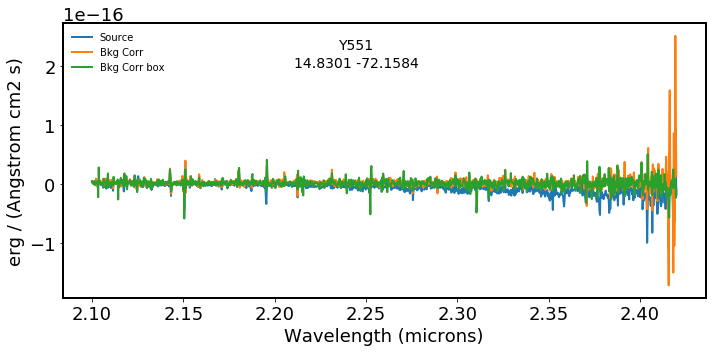

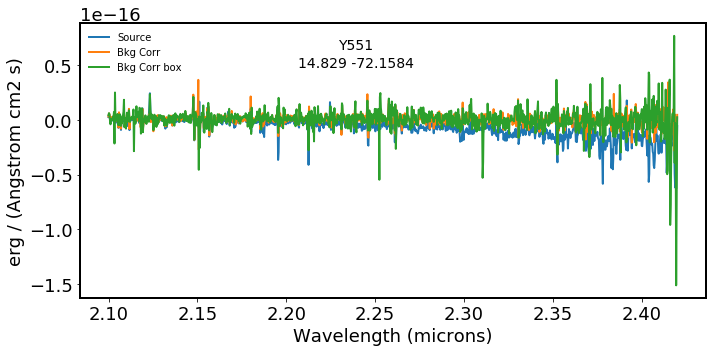

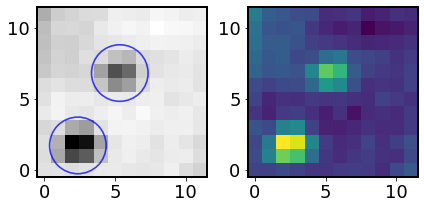

In [12]:
if len(sources) > 0:
    print()            
    for col in sources.colnames:
        sources[col].info.format = '%.8g'  # for consistent table output

    print(sources)                  

    # From the list of sources in the field get their RA and DEC (ICRS)
    print()

    # Positions in pixels
    positions = Table([sources['xcentroid'], sources['ycentroid']])

    # Instantiate WCS object
    w = WCS(cont_img.header)

    # Convert to RA & Dec (ICRS)
    radec_lst = w.pixel_to_world(sources['xcentroid'], sources['ycentroid'])
    
    #-----------------------------------------------------  
    # We are now entering a loop which does multiple processing steps on each 
    # point source detected in the cube
    
    for count_s, _ in enumerate(sources):
        print(radec_lst[count_s].to_string('hmsdms'))
        name_val.append(name)
        source_val.append(count_s)
        ra_val.append(radec_lst[count_s].ra.deg)
        dec_val.append(radec_lst[count_s].dec.deg)
        
        #-----------------------------------------------------           
        # Aperture Extract spectrum of point source - using a circular aperture

        # Size of frame 
        ysize_pix = cmin.shape[1]
        xsize_pix = cmin.shape[2]

        # Set up some centroid pixel for the source 
        ycent_pix = sources['ycentroid'][count_s]
        xcent_pix = sources['xcentroid'][count_s]

        # Make an aperture radius for source
        # If made into a function this value should not be hardcoded
        aperture_rad_pix = 2

        # Make a masked array for the aperture
        yy, xx = np.indices([ysize_pix,xsize_pix], dtype = 'float')
        radius = ((yy-ycent_pix)**2 + (xx-xcent_pix)**2)**0.5

        # Select pixels within the aperture radius
        mask = radius <= aperture_rad_pix

        # Make a masked cube
        maskedcube = cmin.with_mask(mask)

        # Pixels in aperture
        pix_in_ap = np.count_nonzero(mask == 1)

        # Extract the spectrum from only the circular aperture - use sum
        spectrum = maskedcube.sum(axis = (1,2))

        # Extract the noise spectrum for the source
        noisespectrum = maskedcube.std(axis = (1,2))

        # Measure a spectrum from the background - Use an annulus around the source
        # NOTE: Hardcoded values in for annulus size - improve

        # Select pixels within an annulus
        an_mask = (radius > aperture_rad_pix + 1) & (radius <= aperture_rad_pix + 2)

        # Make a masked cube
        an_maskedcube = cmin.with_mask(an_mask)

        # Extract the background spectrum from only the annulus
        bkg_spectrum = an_maskedcube.median(axis = (1,2))

        # Background corrected spectrum - annulus
        corr_sp = spectrum - (bkg_spectrum * pix_in_ap)

        # Try measuring a spectrum from the background -> Use a box away from source.
        # NOTE: Hardcoded values in for box region - improve

        bkgcube = cmin[: , 1:3, 10:13]
        bkgbox_spectrum = bkgcube.median(axis = (1,2))
        bkg_img = bkgcube.median(axis = 0)

        # Background corrected spectrum - box
        corr_sp_box = spectrum - (bkgbox_spectrum * pix_in_ap)
                
        #-----------------------------------------------------               
        # Plot the spectrum extracted from circular aperture via: a sum extraction
        
        plt.figure(figsize = (10,5))

        plt.plot(maskedcube.spectral_axis.value, spectrum.value,
                 label = 'Source')
        plt.plot(maskedcube.spectral_axis.value, corr_sp.value,
                 label = 'Bkg Corr')
        plt.plot(maskedcube.spectral_axis.value, corr_sp_box.value,
                 label = 'Bkg Corr box')

        plt.xlabel('Wavelength (microns)')
        plt.ylabel(spectrum.unit)

        plt.gcf().text(0.5, 0.85, name, fontsize = 14, ha = 'center')

        plt.gcf().text(0.5, 0.80, radec_lst[count_s].to_string('decimal'),
                       ha = 'center', fontsize=14)

        plt.legend(frameon = False, fontsize = 'medium')
        plt.tight_layout()
        plt.show()
        plt.close()
        
        #-----------------------------------------------------  
        # Convert flux from erg / (Angstrom cm2 s) to Jy 
        
        spectrumJy = spectrum.to(
            u.Jy, equivalencies = u.spectral_density(maskedcube.spectral_axis))

        corr_sp_Jy = corr_sp.to(
            u.Jy, equivalencies = u.spectral_density(maskedcube.spectral_axis))

        corr_sp_box_Jy = corr_sp_box.to(
            u.Jy, equivalencies= u.spectral_density(maskedcube.spectral_axis))

        noiseSp_Jy = noisespectrum.to(
            u.Jy, equivalencies = u.spectral_density(maskedcube.spectral_axis))

        #-----------------------------------------------------
        # Save each extracted spectrum to a file

        # Set an output name
        spec_outname = name + "_" + str(count_s) + "_" + "spec"

        # Make output table 
        specdata_tab = Table([maskedcube.spectral_axis, corr_sp_Jy, noiseSp_Jy,
                              spectrumJy, corr_sp_box_Jy],
                             names=['wave_mum', 'cspec_Jy', 'err_fl_Jy',
                                    'spec_Jy', 'cSpec_box_Jy'])

        # Write the file
        # ascii.write(specdata_tab, outdir_spectra + spec_outname +".csv",
        #             format = 'csv', overwrite = True)

    #-----------------------------------------------------
    # Do aperture photometry on the sources - Only if using sum of image

    # Take list of star positions from DAOFIND use this to define an aperture
    if len(sources) == 2:                         # To overcome in array order 
        sources = vstack([sources, sources])             
        positions_pix = (sources['xcentroid'], sources['ycentroid'])
    else:
        positions_pix = (sources['xcentroid'], sources['ycentroid'])

    apertures = CircularAperture(positions_pix, r = 2.)   # Aperture radius = 2 pixels
    
    #-----------------------------------------------------
    # As a check to make sure all obvious point sources have been identified
    # plot the cube with the NaN borders removed and overplot the apertures
    # for the extracted sources
    plt.figure()

    plt.subplot(1, 2, 1)
    plt.imshow(cont_img.value, cmap='Greys', origin='lower')
    apertures.plot(color='blue', lw=1.5, alpha=0.5)

    plt.subplot(1, 2, 2)
    plt.imshow(cont_img.value, origin='lower')

    plt.tight_layout()
    plt.show()
    plt.close()

else:  
    # Plot the cube with the NaN borders removed 
    plt.figure()
    plt.imshow(cont_img.value, origin='lower')
    plt.tight_layout()
    plt.show()
    plt.close()

In [13]:
# Make table of extracted sources
source_extspec_tab = Table([name_val, source_val, ra_val, dec_val], 
                           names = ("name", "source_no", "ra", "dec"))
print(source_extspec_tab)   

name source_no         ra                dec        
---- --------- ------------------ ------------------
Y551         0 14.830119062034905 -72.15837463495436
Y551         1 14.829047135765496 -72.15837513138561


##  Data analysis - on the extracted spectra using `specutils`
With the present lack of JWST flight data, we instead use the SWS spectra of an dusty AGB star, a cool M-star.

In [14]:
# Set the paths to the spectral data extracted from the datacube above
dusty_AGB_spec_file = data_in_path + '63702662.txt'

spectra_file = dusty_AGB_spec_file

In [15]:
# Read in the spectra - as saved as text files & do some housekeeping
data = ascii.read(spectra_file)

if data.colnames[0] == 'col1':
    data['col1'].name = 'wave_mum'
    data['col2'].name = 'cspec_Jy'            
    data['col3'].name = 'err_fl_Jy'         

wav = data['wave_mum'] * u.micron  # Wavelength: microns
fl = data['cspec_Jy'] * u.Jy       # Fnu:  Jy
efl = data['err_fl_Jy'] * u.Jy     # Error flux: Jy

# Make a 1D spectrum object
spec = Spectrum1D(spectral_axis = wav, flux = fl, uncertainty = StdDevUncertainty(efl))

**Note** Reading in a spectra comprised of multiple spectral components this file may have a spectral order column. In
many instances these orders are not correctly stitched together due to issues with background and flux calibration. A
spectral file with an order column that can read into the `Spectrum1D` is necessary to do corrections and scaling on
each segment individually to fix the jumps between the spectra.

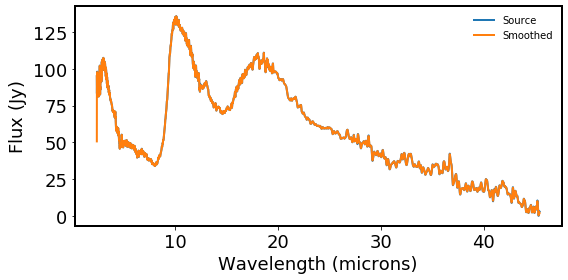

In [16]:
# Apply a 5 pixel boxcar smoothing to the spectrum
spec_bsmooth = box_smooth(spec, width = 5)   

# Plot the spectrum & smoothed spectrum to inspect features 
plt.figure(figsize = (8,4))
plt.plot(spec.spectral_axis, spec.flux, label = 'Source')
plt.plot(spec.spectral_axis, spec_bsmooth.flux, label = 'Smoothed')
plt.xlabel('Wavelength (microns)')
plt.ylabel("Flux ({:latex})".format(spec.flux.unit))

plt.legend(frameon = False, fontsize = 'medium')
plt.tight_layout()
plt.show()
plt.close()

### Fit a continuum - find the best-fitting template (stellar photosphere model or blackbody)

**Note** - Would idealy like to fit the photosphere with a set of Phoenix Models - but cant get that to work.
I think `template_comparison` may be a good function here to work with the Phoenix Models which have been setup to
interface with `pysynphot`.

For now switching to a blackbody.

- For AGB stars with a photosphere component fit a stellar photosphere model or a blackbody to short wavelength end of
the spectra

In [17]:
def blackbody_Fnu(lam, T, A):
    """ Blackbody as a function of wavelength (um) and temperature (K).
        Function returns the Planck function in f_nu units
        # [Y Jy] = 1.0E+23 * [X erg/cm^2/s/Hz] = 10E+26  [X Watts/m^2/Hz]
    """
    from scipy.constants import h, k, c
    lam = 1e-6 * lam                                              # convert to metres
    bb_nu = 2*h*c / (lam**3 * (np.exp(h*c / (lam*k*T)) - 1))      # units of W/m^2/Hz/Steradian ; f_nu units
    return A * bb_nu

In [18]:
# Only want to fit to a small wavelength range at the start of the spectra
phot_fit_region = [3.0, 9.4]  # Microns

# Trim the specrum to the region showing a stellar photosphere
sub_region_phot = SpectralRegion([(phot_fit_region[0], phot_fit_region[1])] * u.micron)
sub_spectrum_phot = extract_region(spec, sub_region_phot)

In [19]:
# fit BB to the data
def phot_fn(wa, T1, A):
    return blackbody_Fnu(wa, T1, A) 

popt, pcov = curve_fit(phot_fn, sub_spectrum_phot.spectral_axis.value,
                       sub_spectrum_phot.flux.value, p0=(3000, 10000),
                       sigma=sub_spectrum_phot.uncertainty.quantity)

# Get the best fitting parameter value and their 1 sigma errors
best_t1, best_a1 = popt
sigma_t1, sigma_a1 = np.sqrt(np.diag(pcov))

ybest = blackbody_Fnu(spec.spectral_axis.value, best_t1, best_a1)

print ('Parameters of best-fitting model:')
print ('T1 = %.2f +/- %.2f' % (best_t1, sigma_t1))

degrees_of_freedom = len(sub_spectrum_phot.spectral_axis.value) - 2

resid = (sub_spectrum_phot.flux.value - phot_fn(sub_spectrum_phot.spectral_axis.value, *popt)) \
        / sub_spectrum_phot.uncertainty.quantity

chisq = np.dot(resid, resid)

print ('nchi2 %.2f' % (chisq.value / degrees_of_freedom))

Parameters of best-fitting model:
T1 = 2361.46 +/- 20.80
nchi2 828.47


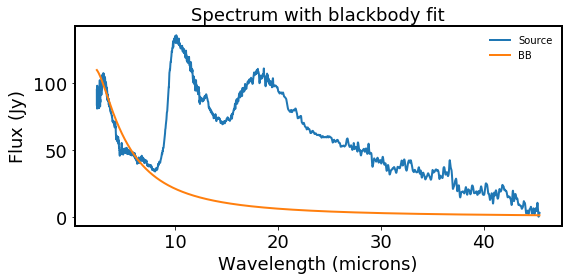

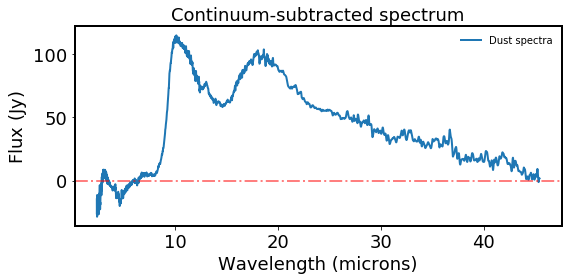

In [20]:
# Plot the spectrum & the model fit to the short wavelength region of the data.
plt.figure(figsize = (8,4))
plt.plot(spec.spectral_axis, spec.flux, label = 'Source')
plt.plot(spec.spectral_axis, ybest, label = 'BB')
plt.xlabel('Wavelength (microns)')
plt.ylabel("Flux ({:latex})".format(spec.flux.unit))
plt.title("Spectrum with blackbody fit")
plt.legend(frameon = False, fontsize = 'medium')
plt.tight_layout()
plt.show()
plt.close()

# Now subtract the BB and plot the underlying dust continuum
plt.figure(figsize = (8,4))
plt.plot(spec.spectral_axis, spec.flux.value - ybest, label = 'Dust spectra')
plt.axhline(0, color='r', linestyle = 'dashdot', alpha=0.5)
plt.xlabel('Wavelength (microns)')
plt.ylabel("Flux ({:latex})".format(spec.flux.unit))
plt.title("Continuum-subtracted spectrum")
plt.legend(frameon = False, fontsize = 'medium')
plt.tight_layout()
plt.show()
plt.close()

### Now have the dust continuum want to look for features and measure their properties.

Want to find:
- Equivalent width
- Equivalent flux
- Optical depth
- Centroids = wavelength with half the flux on either side

#### As an example lets focus on the amorphous silicate 10 micron region.

**Method - used repeatedly**

- Fit a spline to the photosphere continuum subtracted spectra excluding the feature in this fit.
- Trim the spectra to that wavelength region as the spline is now a different size to the full wavelength range of the
spectra.
- Make a continuum subtracted and and continuum normalised spectra.
- Convert the units of the flux from Jy to W/m^2/wavelength for nice units post line integration. 
- Determine the feature line flux in units of W/m^2 and the feature centroid. Use continuum subtracted spectra.
- Determine the feature equivalent width. Use continuum normalised spectra.
- Make sure errors have been propagated correctly.
- Store these results in a table 
- Several molecular and dust features are normally present in the spectra. Repeat for each feature.

**Note**
This seems like a long winded way to do this. Is there a simpler approach?

> For instance a tool that takes four wavelengths, fits a line using the data from  lam0 to lam1 and lam2 to lam3, then
>passes the continuum-subtracted  spectrum for line integration from lam1 to lam2 with error propagation is needed
>several times for dust features. But with the current spectra1d framework this takes many steps to write manually and
>is beyond tedious after doing this for 2 features let alone 20+.  Similar framework is also needed for the integrated
>line centroid with uncertainty, and the extracted equivalent width.

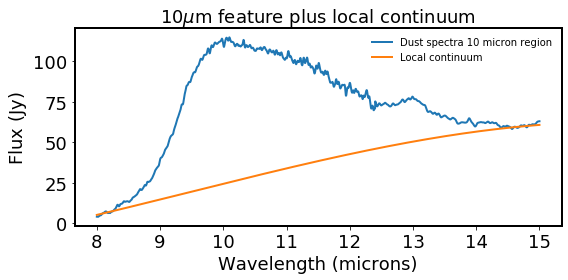

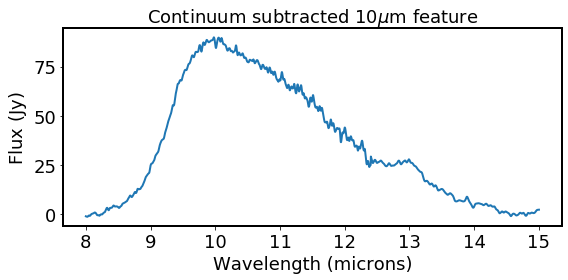

In [21]:
# Fit a spline to the 10 micron feature to isolate it.

bbsub_spectra = spec - ybest     # continuum subtracted spectra - Dust only

# Fit a local continuum between the flux densities at: 8.0 - 8.1 & 14.9 - 15.0 microns
# (i.e. excluding the line itself)

sw_region = 8.0   #lam0
sw_line = 8.1     #lam1
lw_line = 14.9    #lam2
lw_region = 15.0  #lam3

# Zoom in on the line complex & extract
line_reg_10 = SpectralRegion([(sw_region*u.um, lw_region*u.um)])
line_spec = extract_region(bbsub_spectra, line_reg_10)

# Fit a local continuum - exclude the actual dust feature when doing the fit

lgl_fit = fit_generic_continuum(line_spec, 
                                exclude_regions = SpectralRegion([(sw_line*u.um, 
                                                                   lw_line*u.um)])) 

# Determine Y values of the line continuum
line_y_continuum = lgl_fit(line_spec.spectral_axis) 

#-----------------------------------------------------------------
# Generate a continuum subtracted and continuum normalised spectra

line_spec_norm =line_spec / line_y_continuum

line_spec_consub = line_spec - line_y_continuum

#-----------------------------------------------------------------
# Plot the dust feature & continuum fit to the region

plt.figure(figsize = (8, 4))

plt.plot(line_spec.spectral_axis, line_spec.flux.value,
         label = 'Dust spectra 10 micron region')

plt.plot(line_spec.spectral_axis, line_y_continuum, label = 'Local continuum')

plt.xlabel('Wavelength (microns)')
plt.ylabel("Flux ({:latex})".format(spec.flux.unit))
plt.title("10$\mu$m feature plus local continuum")
plt.legend(frameon = False, fontsize = 'medium')
plt.tight_layout()
plt.show()
plt.close()

#-----------------------------------------------------------------
# Plot the continuum subtracted 10 micron feature

plt.figure(figsize = (8,4))

plt.plot(line_spec_consub.spectral_axis, line_spec_consub.flux,
         label = 'continuum subtracted')

plt.xlabel('Wavelength (microns)')
plt.ylabel("Flux ({:latex})".format(spec.flux.unit))
plt.title("Continuum subtracted 10$\mu$m feature")
plt.tight_layout()
plt.show()
plt.close()

In [22]:
# Calculate the Line flux; Line Centroid; Equivalent width
# NOTE: Where are errors computed with these functions?

line_centroid = centroid(line_spec_consub, SpectralRegion(sw_line*u.um, lw_line*u.um))

line_flux_val = line_flux(line_spec_consub, SpectralRegion(sw_line*u.um, lw_line*u.um))

equivalent_width_val = equivalent_width(line_spec_norm)

# Hack to convert the line flux value into more conventional units
# Necessary as spectra has mixed units: f_nu+lambda
line_flux_val = (line_flux_val * u.micron).to(u.W * u.m**-2 * u.micron,
                                              u.spectral_density(line_centroid)) / u.micron

print("Line_centroid: {:.6} ".format(line_centroid))
print("Integrated line_flux: {:.6} ".format(line_flux_val))
print("Equivalent width: {:.6} ".format(equivalent_width_val))


Line_centroid: 10.722 micron 
Integrated line_flux: 6.51116e-12 W / m2 
Equivalent width: -8.85904 micron 


**Developer note** The hack in the cell above is necessary, as the line flux computed by `specutils` would return
units of Jy micron and it is hard to convert this into conventional units within the current `specutils` framework.
Line flux units should be in units of in W/m^2. Implementing a simple way to convert the flux and associate error to
other units when dealing with a 1d spectal object with "mixed" spectral x and y axis units seems necessary.

In [23]:
# Compute the optical depth of the 10 micron feature
tau = -(np.log(line_spec.flux.value / line_y_continuum.value))

optdepth_spec = Spectrum1D(spectral_axis = line_spec.spectral_axis,
                           flux = tau*(u.Jy/u.Jy))
        

**Developer note** Trying to put optical depth into a Spectrum1D object results in an error as no units.
But the optical depth is unit-less - using (u.Jy/u.Jy) as work arround.

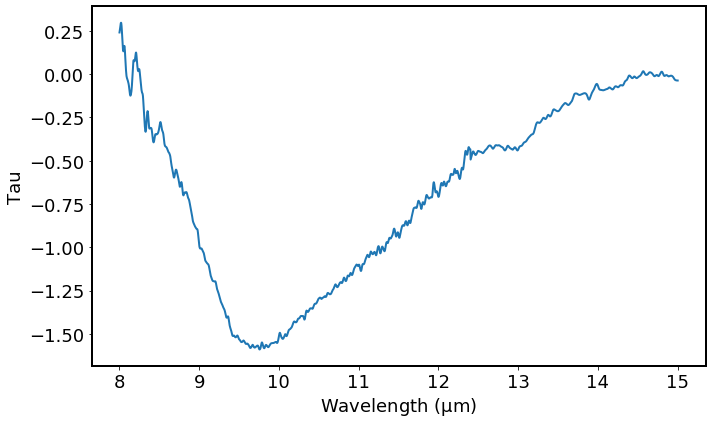

In [24]:
# Plot the optical depth of the 10 micron region vs wavelength
plt.figure(figsize = (10,6))
plt.plot(optdepth_spec.spectral_axis, optdepth_spec.flux)
plt.xlabel("Wavelength ({:latex})".format(spec.spectral_axis.unit))
plt.ylabel('Tau') 
plt.tight_layout()
plt.show()
plt.close()

**Note** At this point repeat *all* the steps above to isolate solid-state features e.g. for the forsterite feature at
at approx 13.3 microns.

#### Now try looking for low crystalline silicate features  at 23, 28, 33 microns in the spectra.

In [25]:
bbsub_spectra = spec - ybest  # photosphere continuum subtracted spectra

spline_points = [20.0, 21.3, 22.0, 24.4, 25.5, 33.8, 35.9] * u.micron  

fluxc_resample = SplineInterpolatedResampler()

# Generate a spline fit to the dust continuum
spline_spec = fluxc_resample(bbsub_spectra, spline_points) 

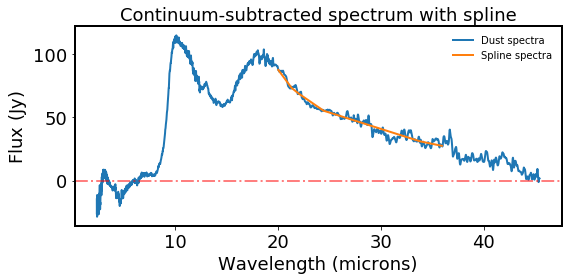

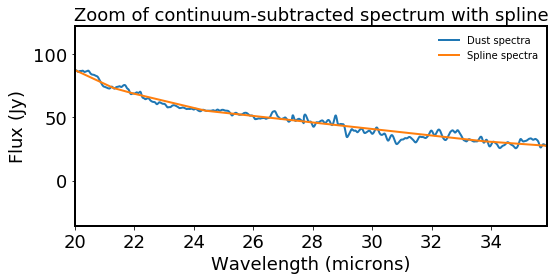

In [26]:
# Plot the underlying dust continuum and spline fit
plt.figure(figsize = (8,4))
plt.plot(bbsub_spectra.spectral_axis, bbsub_spectra.flux.value, label = 'Dust spectra')
plt.plot(spline_spec.spectral_axis, spline_spec.flux.value, label = 'Spline spectra')

plt.axhline(0, color='r', linestyle='dashdot', alpha=0.5)

plt.xlabel('Wavelength (microns)')
plt.ylabel("Flux ({:latex})".format(spec.flux.unit))
plt.title("Continuum-subtracted spectrum with spline")
plt.legend(frameon = False, fontsize = 'medium')
plt.tight_layout()
plt.show()
plt.close()

# Plot the underlying dust continuum and spline fit
plt.figure(figsize = (8,4))
plt.plot(bbsub_spectra.spectral_axis, bbsub_spectra.flux.value, label = 'Dust spectra')
plt.plot(spline_spec.spectral_axis, spline_spec.flux.value, label = 'Spline spectra')

plt.xlim(spline_points[0].value, spline_points[-1].value)

plt.xlabel('Wavelength (microns)')
plt.ylabel("Flux ({:latex})".format(spec.flux.unit))
plt.title("Zoom of continuum-subtracted spectrum with spline")
plt.legend(frameon = False, fontsize = 'medium')
plt.tight_layout()
plt.show()
plt.close()

**Developer note** By fitting a spline to a sub region the spectral shapes are no longer the same.
` bbsub_spectra.flux.value - spline_spec.flux.value` now brakes. Would need to trim the spectrum to the spline size to
start looking closely for low contrast dust features and again measure their properties (see above). Some  wrapper to
stop repeating the same steps over and over would be nice.

## Additional Resources

- [PampelMuse](https://gitlab.gwdg.de/skamann/pampelmuse)
- [CASA](https://casa.nrao.edu/Release3.4.0/docs/UserMan/UserManse41.html)

## About this notebook
**Author:** Olivia Jones, Project Scientist, UK ATC.
**Updated On:** 2020-08-11

***

[Top of Page](#top)